In [91]:
# urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
# window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n'))); (скрипт взят у Джереми)

In [1]:
from matplotlib.pylab import plt
%matplotlib inline
from PIL import Image
import requests
from io import BytesIO
import numpy as np

In [2]:
import urllib3

urllib3.disable_warnings()

In [3]:
import pandas as pd

In [4]:
df_bowie = pd.read_csv('bowie_color.csv',error_bad_lines=False, header = None)

b'Skipping line 3: expected 1 fields, saw 2\nSkipping line 24: expected 1 fields, saw 4\nSkipping line 30: expected 1 fields, saw 4\nSkipping line 97: expected 1 fields, saw 3\nSkipping line 99: expected 1 fields, saw 3\n'


In [5]:
df_bowl = pd.read_csv('salatnic.csv',error_bad_lines=False, header = None)

b'Skipping line 49: expected 1 fields, saw 2\n'


In [6]:
list(df_bowie.columns.values)
df_bowie[0][0]

'https://pixel.nymag.com/imgs/daily/vulture/2016/01/12/12-david-bowie.w700.h700.jpg'

In [7]:
example_url = df_bowie[0][1]

In [8]:
response = requests.get(example_url)
img = Image.open(BytesIO(response.content))

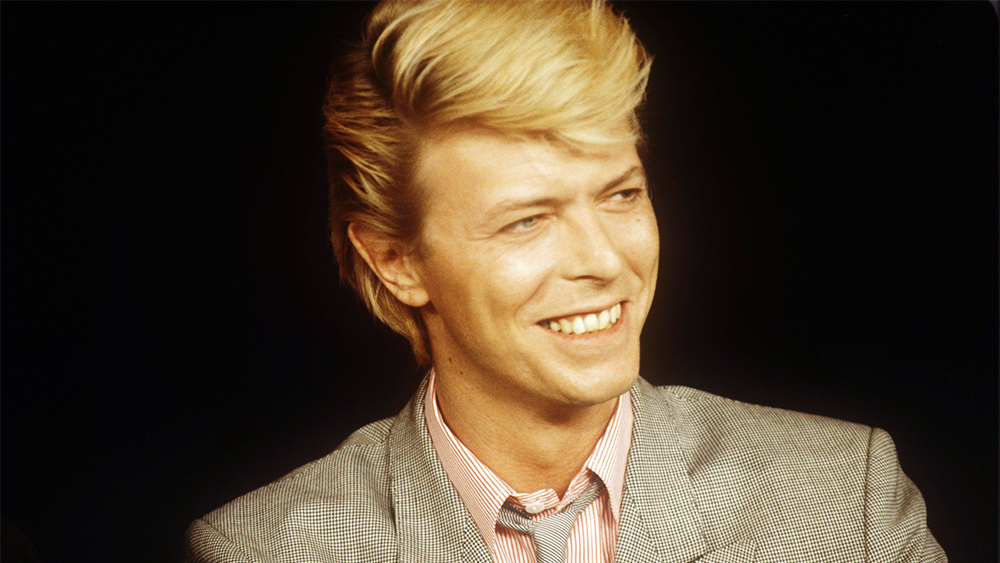

In [9]:
img

In [10]:
img_rsz = img.resize(size=(224,224))

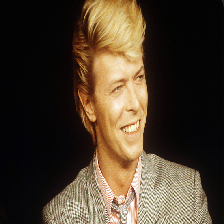

In [11]:
img_rsz

In [12]:
imp_np = np.array(img_rsz)

In [13]:
imp_np.shape

(224, 224, 3)

In [14]:
x = np.array([imp_np, imp_np])
x.shape

(2, 224, 224, 3)

In [15]:
url_bowie_lst = []
for url_bowie in df_bowie[0]:
    try:
        response = requests.get(url_bowie, verify = False)
        img = Image.open(BytesIO(response.content))
        img_rsz = img.resize(size=(224,224))
        imp_np = np.array(img_rsz)
        if imp_np.shape[2] == 3:
            url_bowie_lst.append(url_bowie)
            #print(imp_np.shape[2])
    except:
        pass

/home/ptizza/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:771: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [16]:
print(len(df_bowie[0]),len(url_bowie_lst))

95 90


In [17]:
url_bowl_lst = []
for url_bowl in df_bowl[0]:
    try:
        response = requests.get(url_bowl, verify = False)
        img = Image.open(BytesIO(response.content))
        img_rsz = img.resize(size=(224,224))
        imp_np = np.array(img_rsz)
        if imp_np.shape[2] == 3:
            url_bowl_lst.append(url_bowl)
        #print(imp_np.shape)
    except:
        pass

In [18]:
print(len(df_bowl[0]), len(url_bowl_lst))

199 177


In [19]:
np_bowie = np.array([np.array(Image.open(BytesIO(requests.get(url_bowie, verify = False).content)).resize(size=(224,224))) for url_bowie in url_bowie_lst])

In [20]:
np_bowie.shape

(90, 224, 224, 3)

In [21]:
np_bowl = np.array([np.array(Image.open(BytesIO(requests.get(url_bowl, verify = False).content)).resize(size=(224,224))) for url_bowl in url_bowl_lst])

In [22]:
np_bowl.shape

(177, 224, 224, 3)

In [23]:
np_bowie_y = np.full((np_bowie.shape[0], 1), 0, dtype=int)

In [24]:
np_bowie_y.shape

(90, 1)

In [25]:
np_bowl_y = np.full((np_bowl.shape[0], 1), 1, dtype=int)

In [26]:
np_bowl_y.shape

(177, 1)

In [27]:
X = np.concatenate((np_bowie, np_bowl),axis=0)

In [28]:
X.shape

(267, 224, 224, 3)

In [29]:
Y = np.concatenate((np_bowie_y, np_bowl_y),axis=0)

In [30]:
Y.shape

(267, 1)

In [34]:
np.save('X.npy', X) 
np.save('Y.npy', Y) 

In [5]:
X = np.load('X.npy')
Y = np.load('Y.npy')

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [8]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(213, 224, 224, 3) (54, 224, 224, 3) (213, 1) (54, 1)


In [9]:
import tensorflow as tf

In [11]:
tf.__version__

'2.0.0-dev20190315'

In [10]:
print(np.unique(y_train, axis=0),"\n",np.unique(y_test, axis=0))

[[0]
 [1]] 
 [[0]
 [1]]


In [12]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [13]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224,3)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

Epoch 1/5
213/213 [==============================] - 3s 13ms/sample - loss: 153.3296 - accuracy: 0.5399
Epoch 2/5
213/213 [==============================] - 2s 10ms/sample - loss: 169.4307 - accuracy: 0.6056
Epoch 3/5
213/213 [==============================] - 2s 10ms/sample - loss: 89.3931 - accuracy: 0.6995
Epoch 4/5
213/213 [==============================] - 2s 10ms/sample - loss: 47.9242 - accuracy: 0.7840
Epoch 5/5
54/54 [==============================] - 0s 3ms/sample - loss: 19.3151 - accuracy: 0.8889


[19.31512904387933, 0.8888889]

In [13]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(80,3,activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(160,3,activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

Epoch 1/5
213/213 [==============================] - 20s 94ms/sample - loss: 13.4163 - accuracy: 0.5164
Epoch 2/5
213/213 [==============================] - 20s 95ms/sample - loss: 1.7408 - accuracy: 0.6291
Epoch 3/5
213/213 [==============================] - 22s 103ms/sample - loss: 0.4031 - accuracy: 0.8263
Epoch 4/5
213/213 [==============================] - 22s 102ms/sample - loss: 0.3786 - accuracy: 0.8826
Epoch 5/5
54/54 [==============================] - 1s 27ms/sample - loss: 0.2580 - accuracy: 0.9074


[0.25798469892254583, 0.9074074]